In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Geodesics as gd
import Model as md
import cmath as cmt
import glob
import os
import time
from scipy.optimize import curve_fit as cf
from Functions import *

## Monte Carlo Simulation (Swensden-Wang missing)

In [ ]:
for nlayers in range(4,5):
    #Set up model
    p = 5; q = 4
    start = time.time()
    print("Defining model with " + str(nlayers) + " layers", end = '\r')
    model = md.FractonModel(p,q,nlayers, kernel = 'SRG')
    end = time.time()
    elapsed = end-start
    nSpins = len(model.lattice)
    nGeods = len(model.geodesicList)
    print("Finished defining model with " + str(nlayers) + " layers. It took: " + str(round(elapsed,2)) + ' s'+' There are '+str(nSpins)+ ' sites and '+str(nGeods) + ' geodesics' +' '*100)
    #Lattice parameters
    nDecorr = 10 #Steps to decorrelate  
    nMeasurements = nGeods*250 #Number of measurements
    saveFreq = 1000 #Save frequency
    
    # Define the directory where you want to save the files
    save_dir = "../Data/P"+str(p)+"Q"+str(q)+"/"+str(nlayers)+"Layers"
    timeSeries_dir = save_dir+'/Correlations'
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        os.makedirs(timeSeries_dir)

    #Number of spins in the border
    nBorder = len(model.border)
    distances = np.linspace(1,int(nBorder/2), int(nBorder/2))

    #Initialize correlation and states arrays
    corr = np.zeros(int(len(model.border)/2))
    corrTimeSeries = np.zeros((saveFreq,int(len(model.border)/2)))
    
    
    #Initialize save counter
    saveCounter = 0
    elapsed = 0
    freq = 1
    if nlayers > 5:
        freq = 10
    

    ##EntanglementEntropy
    start = time.time()
    ent_entr = entanglement_entropy(model,freq = freq)
    end = time.time()
    print('Entropy took: ' + str(round(end-start,2)) + ' s' + ' '*1000, end = '\n')
    borderCenters = model.centers[model.border]
    blockSizes = np.linspace(1,nBorder,nBorder)
    np.save(os.path.join(save_dir, "EntanglEntr.npy"),ent_entr)
    figEntr,axEntr = plt.subplots()
    axEntr.set_title("Entropy Layers = " + str(nlayers))
    axEntr.plot(blockSizes,ent_entr)
    axEntr.set_ylabel(r'$E_l$')
    axEntr.set_xlabel(r'$l$')
    axEntr.set_xscale('log')
    figEntr.savefig(os.path.join(save_dir, "EntanglEntr.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)

    #Simulation main loop

    for iteration in range(nMeasurements):
        start = time.time()
        model.decorrelate(nDecorr)
        temp = np.array(model.getBorderCorrelations()/nBorder)
        corrTimeSeries[saveCounter,:] = temp/nMeasurements
        corr += temp/nMeasurements
        saveCounter += 1
        end = time.time()
        elapsed += end - start
        if(saveCounter == saveFreq):
            print('Computing correlation. \tPercentage: ' + str(round(iteration/nMeasurements*100)) + '% \t' + str(round(iteration/elapsed)) + ' it/s' + '\t Time remaining: ' + str(round((elapsed*(nMeasurements-iteration)/iteration)/60,2)) +' min     ', end = '\r')
            np.save(os.path.join(save_dir, "Correlation" + ".npy"),np.array(corr))
            np.save(os.path.join(timeSeries_dir, "CorrelationTimeSeries"+str(int(iteration/saveFreq)) + ".npy"),np.array(corrTimeSeries))
            saveCounter = 0
    print('Correlation took: ' + str(round(elapsed,2))+' s'+' '*1000, end = '\n')

    figCorr, axCorr = plt.subplots()
    axCorr.set_title("Correlation Layers = " + str(nlayers))
    axCorr.plot(distances,corr/nMeasurements)
    axCorr.set_ylabel(r'$\left< e_ne_{n+d} \right>$')
    axCorr.set_xlabel(r'$d$')
    figCorr.savefig(os.path.join(save_dir, "CorrelationFigure.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)


    gedsPerLength = geodesicsePerLength(model)
    np.save(os.path.join(save_dir, "NumGeods.npy"),geodesicsePerLength)

## Entanglement entropy with BH

In [2]:
model = md.FractonModel(5,4,7, kernel = 'SRG')
insidePols = insidePolygons(model)
bHoleRads = [0.01,0.31,0.71,0.82,0.89]

In [106]:
borderSize = int(len(model.border))
halfBorderSize = int(len(model.border)/2)
borderPolygons = model.border
entropy = np.zeros((len(bHoleRads),borderSize-1))

step = 5
numStatistics = int(borderSize/step)

for radIdx,rad in enumerate(bHoleRads):
    for size in range(2,halfBorderSize+2):
        sizeBorder = size-1
        complementSize = borderSize-sizeBorder
        startTime = time.time()
        for start in range(numStatistics):
            first = step*start
            last = (step*start+size-1)%borderSize
            for g in range(len(model.geodesicList)):
                if model.geodesicList[g].distanceToOrigin > rad:
                    wedgeGeod = insidePols[g]
                    x = wedgeGeod[first] == -1
                    y = wedgeGeod[last] == -1
                    if bool((x and not y) or (y and not x)):
                                entropy[radIdx,sizeBorder-1] += 1
                                entropy[radIdx,complementSize-1]+=1
        end = time.time()
        elapsed = end-startTime
        message = f'Time remaining: {round(elapsed*(halfBorderSize+1-size)/60,2):.2f} m'
        print(message, end = '\r')
    print(f'Finished black hole with radius {rad:.4f}',end = '\n')
entropy[:,int((borderSize-1)/2)] = entropy[:,int((borderSize-1)/2)]/2 
entropy = entropy/numStatistics
blockSizes = np.linspace(1,borderSize-1,borderSize-1)
np.save("./entropy.py",entropy)

Finished black hole with radius 0.0100
Finished black hole with radius 0.3100
Finished black hole with radius 0.7100
Finished black hole with radius 0.8200
Finished black hole with radius 0.8900


779


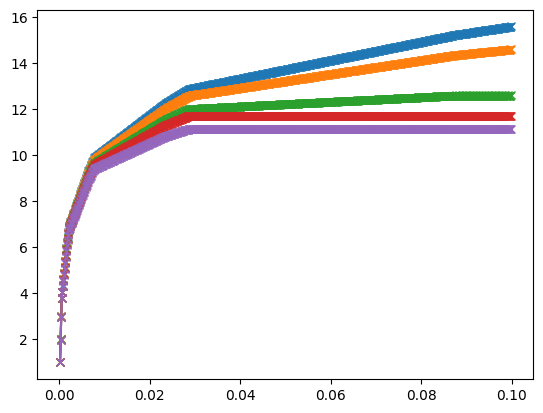

In [177]:
np.save("./entropy.npy",entropy)
blockSizes = np.linspace(1,borderSize-1,borderSize-1)/borderSize
smallL = blockSizes <0.1
print(np.sum(smallL))
for idx in range(5):
    plt.plot(blockSizes[smallL],entropy[idx,smallL],'x-')



In [172]:
def entropyFiniteSize(x,c,a,beta):
    return (c/3)*np.log(1.0/(np.pi*a)*np.sin(np.pi*x/beta))
par1, pcov1 = cf(entropyFiniteSize,blockSizes,entropy[0,:])
print(par1)
print(np.sqrt(pcov1))
print(par2)
print(pcov2)

[6.86972893e+00 1.17570045e-04 1.00004628e+00]
[[4.74546656e-03 5.28038013e-05 1.01066408e-04]
 [5.28038013e-05 5.91666234e-07 1.14044245e-06]
 [1.01066408e-04 1.14044245e-06 6.84823364e-06]]
[ 3.72508219e+00  4.61632306e-06 -6.12920131e+04]
[[ 3.41877231e-03  3.80625926e-08 -7.68655579e+07]
 [ 3.80625926e-08  4.28873222e-13 -5.93274975e+02]
 [-7.68655579e+07 -5.93274975e+02  1.34839766e+21]]


/tmp/ipykernel_300705/499798237.py:2: RuntimeWarning: invalid value encountered in log
  return (c/3)*np.log(1.0/(np.pi*a)*np.sin(np.pi*x/beta))


In [150]:
def entropyFiniteBeta(x,beta):
    return (par1[0]/3)*np.log(beta/(np.pi*par1[1])*np.sin(np.pi*x/beta))

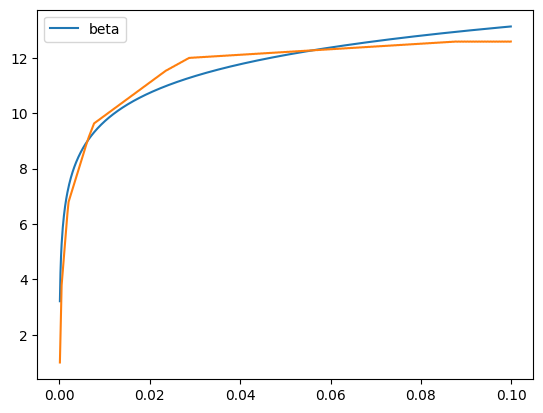

In [168]:
plt.plot(blockSizes[smallL],entropyFiniteSize(blockSizes[smallL],*par2),label = 'beta')
plt.plot(blockSizes[smallL],entropy[2,smallL])

plt.legend()